In [1]:
## Most Important
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## less Important
from functools import partial
import os
from scipy import stats
import missingno as msno
import joblib
import tarfile
import shutil
import urllib

## Sklearn
from sklearn import datasets
## Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
## Metrics
from sklearn.metrics import accuracy_score

## tensorflow & Keras
import tensorflow as tf    ## i will use tf for every thing and for keras using tf.keras
import tensorflow_datasets as tfds

In [2]:
## reproduce the same results
np.random.seed(42)
tf.random.set_seed(42)

## Training RNN for Time Series

In [3]:
## generate function to make timeseries

def generate_time_series(use_batch_size, use_n_steps):
    ''' this function is to create time series Dataset and returns (use_batch_size * use_n_steps * 1)
        i will use dimensionality =1
    Args:
    *****
        (use_batch_size : int) => Number of batches required each batch_size is (timesteps*Dimensions)
        (use_n_steps : int) => Number of timesteps required at each batch
    Returns:
    ********
         returns series of Dataset with shape (use_batch_size * use_n_steps * 1)
        
    '''
    freq1, freq2, offset1, offset2 = np.random.rand(4, use_batch_size, 1)
    time = np.linspace(0, 1, use_n_steps)
    series = 0.5 * np.sin((time - offset1) * (freq1 * 10 + 10)) ## wave 1
    series += 0.2 * np.sin((time - offset2) * (freq2 * 20 + 20)) ## wave 2
    series += 0.1 * (np.random.rand(use_batch_size, use_n_steps) - 0.5) ## + noise
    
    ## extend the third dimension using dimensionality = 1
    series = series[..., np.newaxis]
    return series

In [4]:
## call the function 
batch_size = 10000   
n_steps = 50   ## each batch size contains (50 * 1) (timestps * dimensonlaity)

## Note i will use n_steps in calling the function to be 51 ==> 
## taking the first 50 as Predictors and the final one at each batch as Target required to predict
series_data = generate_time_series(use_batch_size=batch_size, use_n_steps=n_steps+1)
print('series_data.shape =>', series_data.shape)

## split the data
## taking the first 7000 batch for training, next 2000 for validation, final 1000 for test
## for each batch at train or valid or even test, taking the first 50 timesteps as Predictors
## and the final timestep (51) to be the Traget that required to be predicted


## => for train
X_train = series_data[:7000, :n_steps, :]
y_train = series_data[:7000, -1, :]

## => for valid
X_valid = series_data[7000:9000, :n_steps, :]
y_valid = series_data[7000:9000, -1, :]

## => for test
X_test = series_data[9000:, :n_steps, :]
y_test = series_data[9000:, -1, :]


## check shapes
print()
print('X_train.shape =>', X_train.shape)
print('y_train.shape =>', y_train.shape)
print()
print('X_valid.shape =>', X_valid.shape)
print('y_valid.shape =>', y_valid.shape)
print()
print('X_test.shape =>', X_test.shape)
print('y_test.shape =>', y_test.shape)  ## seems Good!

series_data.shape => (10000, 51, 1)

X_train.shape => (7000, 50, 1)
y_train.shape => (7000, 1)

X_valid.shape => (2000, 50, 1)
y_valid.shape => (2000, 1)

X_test.shape => (1000, 50, 1)
y_test.shape => (1000, 1)


`some Visualization for train`

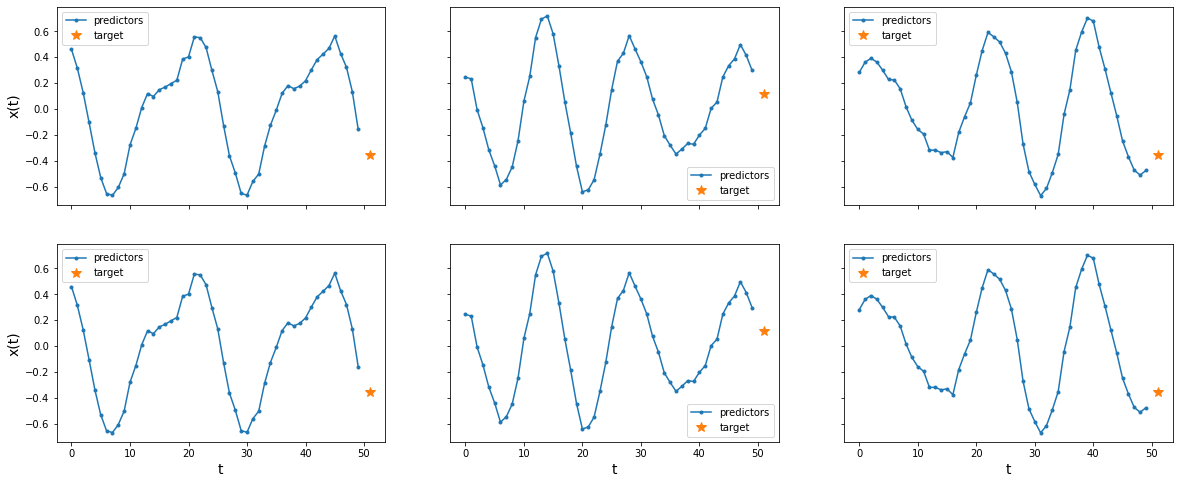

In [5]:
## for train first 6 batches
fig, ax = plt.subplots(2, 3, figsize=(20, 8), sharey=True, sharex=True)

for row in range(2):
    for col in range(3):
        plt.sca(ax[row, col])
        plt.plot(X_train[col], '.-', label='predictors')
        plt.plot(50, y_train[col], '*', markersize=10, label='target')
        if row==1:
            plt.xlabel('t', fontsize=14)
        if col==0:
            plt.ylabel('x(t)', fontsize=14)
        plt.legend()

`some Visualization for valid`

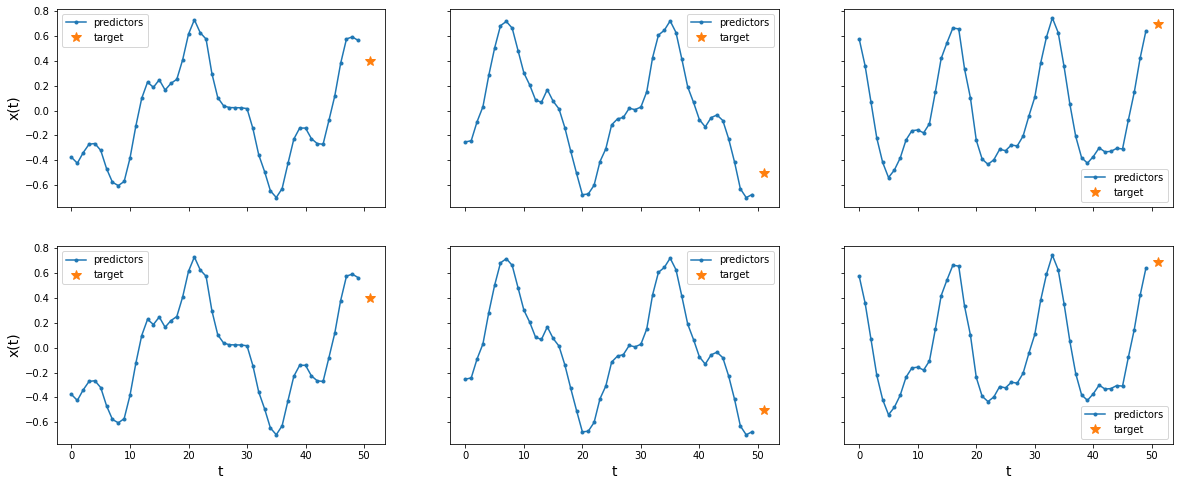

In [6]:
## for valid first 6 batches
fig, ax = plt.subplots(2, 3, figsize=(20, 8), sharey=True, sharex=True)

for row in range(2):
    for col in range(3):
        plt.sca(ax[row, col])
        plt.plot(X_valid[col], '.-', label='predictors')
        plt.plot(50, y_valid[col], '*', markersize=10, label='target')
        if row==1:
            plt.xlabel('t', fontsize=14)
        if col==0:
            plt.ylabel('x(t)', fontsize=14)
        plt.legend()

`some Visualization for test`

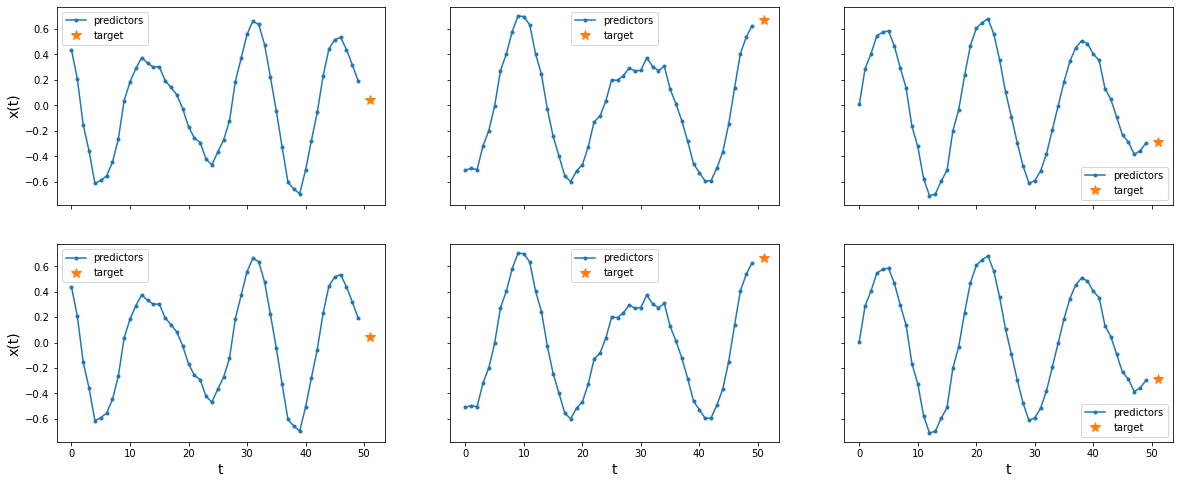

In [7]:
## for test first 6 batches
fig, ax = plt.subplots(2, 3, figsize=(20, 8), sharey=True, sharex=True)

for row in range(2):
    for col in range(3):
        plt.sca(ax[row, col])
        plt.plot(X_test[col], '.-', label='predictors')
        plt.plot(50, y_test[col], '*', markersize=10, label='target')
        if row==1:
            plt.xlabel('t', fontsize=14)
        if col==0:
            plt.ylabel('x(t)', fontsize=14)
        plt.legend()  ## very Good!

## Training

##### `First naive approach is to take the new point (which i want to predict) equal the final step`

In [8]:
## naive approach ==> valid 
y_pred_naive = X_valid[:, -1, :]
## get the mean of this error ==> very very naive
naive_mse_mean = np.mean(tf.keras.losses.mean_squared_error(y_valid, y_pred_naive))
print('naive_mse_mean =>', naive_mse_mean)

naive_mse_mean => 0.02021136609260187


##### `Second approach is to make Simple Linear Combination usign Fully Connected`

In [9]:
## Build simple FC Model
model_fc = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[50, 1]),  ### here training shape batch 50x1
    tf.keras.layers.Dense(1) 
]) 
## check model summary 
## here we have 50 weights as we have 50 timestpes, for example at each batch size for timestep=1
## at each batch size, then timestep=1 it is a feature, then we have 50 features + 1 bias = 51 params

## compile and fit the model
model_fc.compile(loss='mse', optimizer='adam')

history_fc = model_fc.fit(X_train, y_train, 
                          validation_data=(X_valid, y_valid), 
                          epochs=20, batch_size=32)

## loss reaches about MSE = 0.003

Epoch 1/20
219/219 [==============================] - 2s 5ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0061 - val_loss: 0.0062

In [10]:
## get the final loss
linear_loss = history_fc.history['val_loss'][-1]
print('linear_loss =>', linear_loss)

linear_loss => 0.004168086219578981


##### `Third approach is to use SimpleRNN of one layer and one output`

In [11]:
model_simpleRnn = tf.keras.models.Sequential([
    ## by default uses tanh activation function
    ## note the method we write the input_shape here in RNN
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])  
])

## compile and fit the model
model_simpleRnn.compile(loss='mse', optimizer='adam')

history_simpleRnn = model_simpleRnn.fit(X_train, y_train, 
                                        validation_data=(X_valid, y_valid), 
                                        epochs=20, batch_size=32)

## loss reaches about MSE = 0.014

Epoch 1/20
219/219 [==============================] - 39s 177ms/step - loss: 0.0604 - val_loss: 0.0509
Epoch 2/20
219/219 [==============================] - 37s 167ms/step - loss: 0.0406 - val_loss: 0.0342
Epoch 3/20
219/219 [==============================] - 34s 156ms/step - loss: 0.0270 - val_loss: 0.0226
Epoch 4/20
219/219 [==============================] - 32s 146ms/step - loss: 0.0184 - val_loss: 0.0159
Epoch 5/20
219/219 [==============================] - 32s 148ms/step - loss: 0.0141 - val_loss: 0.0129
Epoch 6/20
219/219 [==============================] - 32s 147ms/step - loss: 0.0124 - val_loss: 0.0118
Epoch 7/20
219/219 [==============================] - 33s 153ms/step - loss: 0.0119 - val_loss: 0.0114
Epoch 8/20
219/219 [==============================] - 33s 148ms/step - loss: 0.0117 - val_loss: 0.0113
Epoch 9/20
219/219 [==============================] - 36s 163ms/step - loss: 0.0116 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 35s 161ms/step - l

In [12]:
loss_simpleRNN = history_simpleRnn.history['val_loss'][-1]
print('loss_simpleRNN =>', loss_simpleRNN)

loss_simpleRNN => 0.010874765925109386


## Deep RNN
`We can stack multiple layers in RNN, but note if you pass from RNN layer no.1 to RNN layer no.2, you should make hyperparameter (return_sequence) in layer no.1 to True, to be 3D array else you have an error, and if you pass from RNN layer no.1 to Dense layer no.2, you should set this hyperparameter to false as Dense layer required 2D not 3D and return_sequence=True, return 3D , so in this case we will set return_sequence=False` <br />



``` python
    ## case 1
    tf.keras.layer.SimpleRNN(20, return_sequences=True)
    tf.keras.layer.SimpleRNN(1)
    
    ## case 2
    tf.keras.layer.SimpleRNN(20, return_sequences=False)
    tf.keras.layer.Dense(1)
```

In [13]:
### note that final layer could be SimpleRNN or Dense layer if you want to change your activation
## SimpleRNN uses tanh(hybeploic) but you can use Dense and change it 
## but you should apply waht I said in the previous cell
model_deepRNN_1 = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(20, return_sequences=True),
    tf.keras.layers.SimpleRNN(1)
])

## compile and fit the model for only 6 epochs ==> needs more but i save my time
model_deepRNN_1.compile(loss='mse', optimizer='adam')

history_deepRNN_1 = model_deepRNN_1.fit(X_train, y_train, 
                                        validation_data=(X_valid, y_valid), 
                                        epochs=6, batch_size=32)

## loss through only 6 epochs reaches about 0.0032
## you can go much deeper for epochs and reduce that error more and more about 0.003
## the best model till here

Epoch 1/6
219/219 [==============================] - 128s 576ms/step - loss: 0.0175 - val_loss: 0.0051
Epoch 2/6
219/219 [==============================] - 121s 551ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 3/6
219/219 [==============================] - 120s 550ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 4/6
219/219 [==============================] - 121s 552ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/6
219/219 [==============================] - 121s 555ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/6
219/219 [==============================] - 121s 553ms/step - loss: 0.0030 - val_loss: 0.0029


In [14]:
loss_deepRNN = history_deepRNN_1.history['val_loss'][-1]
print('loss_deepRNN =>', loss_deepRNN)

loss_deepRNN => 0.0028663885314017534


## Forecasting Several Steps Ahead
`What if we want not only the next value waht about let say 10 values ==> we have many Approaches`

##### `First Approach is to predict only one value, then conactenate as it was one of the data and so on for the required steps`

In [15]:
## using model ===> model_deepRNN_1
## making new Dataset

np.random.seed(123)
tf.random.set_seed(123)
## taking the next 60 timesteps 50 as predictors and 10 as targets and only one batch_size 
new_series = generate_time_series(use_batch_size=1, use_n_steps=n_steps+10) 
print('new_series.shape =>', new_series.shape)

## split
X_new = new_series[:, :n_steps, :]
y_new = new_series[:, n_steps:, :]
print('X_new.shape =>', X_new.shape)
print('y_new.shape =>', y_new.shape)

new_series.shape => (1, 60, 1)
X_new.shape => (1, 50, 1)
y_new.shape => (1, 10, 1)


### 1. First Option => Concatenate Method

##### `new dataset`

loss_mse_concat => 0.0669547034007796



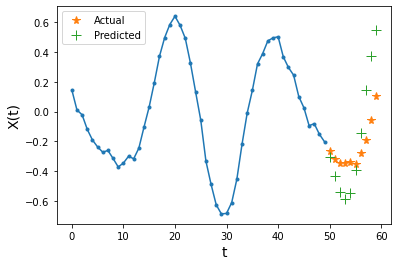

In [16]:
## =====> loop for next 10 values
## copy X_new
X_loop = np.copy(X_new)
for step_head in range(10):
    ## add new axis to be 3D
    y_pred_each_step = model_deepRNN_1.predict(X_loop[:, step_head:])[..., np.newaxis]  
    ## concatenate
    X_loop = np.concatenate([X_loop, y_pred_each_step], axis=1)
    
## taking only the results from (50 to final)
y_pred_conact = X_loop[:, n_steps:, :]

### test the MSE

loss_mse_concat = np.mean(tf.keras.losses.mean_squared_error(y_new, y_pred_conact))
print('loss_mse_concat =>', loss_mse_concat)

print()

### Visualize these resutls
plt.plot(np.squeeze(X_new), '.-')
plt.plot(range(50, 60), np.squeeze(y_new), '*', markersize=8, label='Actual')
plt.plot(range(50, 60), np.squeeze(y_pred_conact), '+', markersize=10, label='Predicted')
plt.xlabel('t', fontsize=14)
plt.ylabel('X(t)', fontsize=14)
plt.legend()
plt.show()

##### `you can make this trick and evaluate this on valid and test set, but note that you should change the taregt to be not only one value for each batch, but 10 (as my example here) for each batch`

In [17]:
## call the function
batch_size = 10000
n_steps = 50  ## as previous

## make the steps 50 for predictors and 10 as a targets
series_10_outs = generate_time_series(use_batch_size=batch_size, use_n_steps=n_steps+10) 
print('series_10_outs.shape =>', series_10_outs.shape)

## split as previous, except the target will be not only one value per batch but 10 values
X_train, y_train = series_10_outs[:7000, :n_steps, :], series_10_outs[:7000, n_steps:, :]
X_valid, y_valid = series_10_outs[7000:9000, :n_steps, :], series_10_outs[7000:9000, n_steps:, :]
X_test, y_test = series_10_outs[9000:, :n_steps, :], series_10_outs[9000:, n_steps:, :]

## check shapes
print()
print('X_train.shape =>', X_train.shape)
print('y_train.shape =>', y_train.shape)
print()
print('X_valid.shape =>', X_valid.shape)
print('y_valid.shape =>', y_valid.shape)
print()
print('X_test.shape =>', X_test.shape)
print('y_test.shape =>', y_test.shape)  ## seems Good!

series_10_outs.shape => (10000, 60, 1)

X_train.shape => (7000, 50, 1)
y_train.shape => (7000, 10, 1)

X_valid.shape => (2000, 50, 1)
y_valid.shape => (2000, 10, 1)

X_test.shape => (1000, 50, 1)
y_test.shape => (1000, 10, 1)


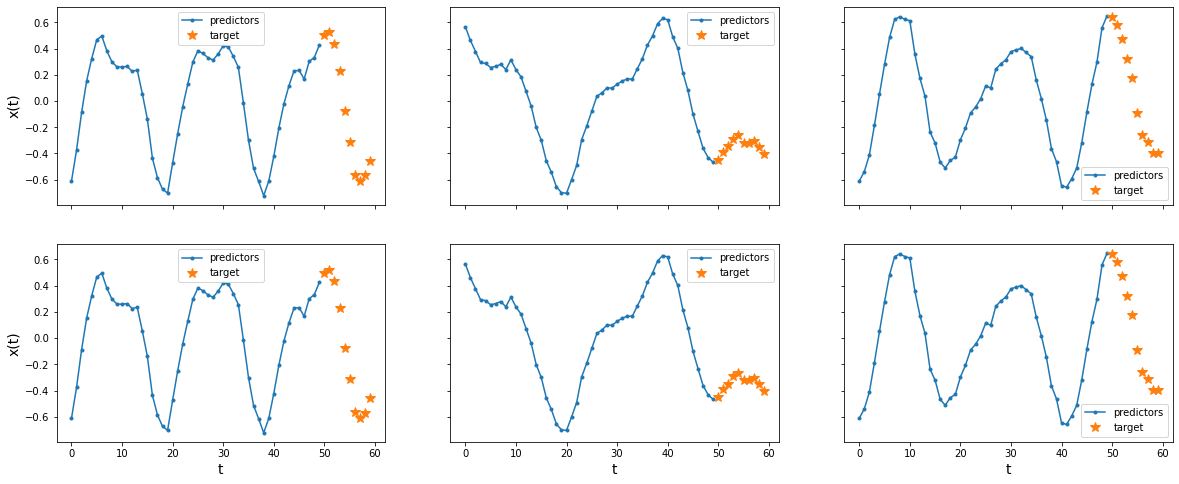

In [18]:
## for train first 6 batches
fig, ax = plt.subplots(2, 3, figsize=(20, 8), sharey=True, sharex=True)

for row in range(2):
    for col in range(3):
        plt.sca(ax[row, col])
        plt.plot(X_train[col], '.-', label='predictors')
        plt.plot(range(50, 60), y_train[col], '*', markersize=10, label='target')
        if row==1:
            plt.xlabel('t', fontsize=14)
        if col==0:
            plt.ylabel('x(t)', fontsize=14)
        plt.legend()  ## here not only one target , now 10 target values

##### `Evaluate this Method on Valid`

loss_mse_concat on valid set => 0.03673139496228415



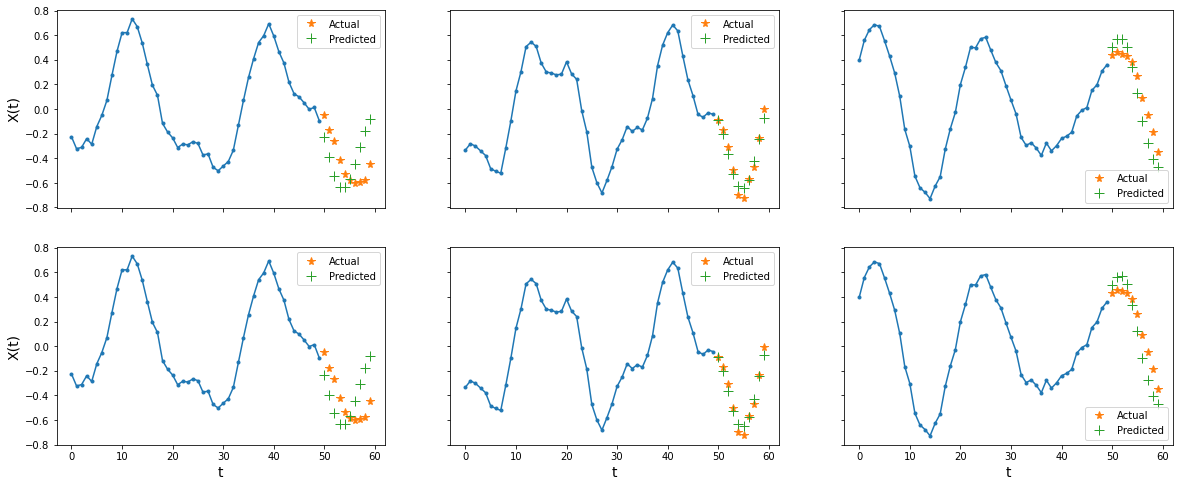

In [19]:
## =====> loop for next 10 values
## copy X_valid
np.random.seed(42)
tf.random.set_seed(42)

X_valid_loop = np.copy(X_valid)
for step_head in range(10):
    ## add new axis to be 3D
    y_pred_each_step = model_deepRNN_1.predict(X_valid_loop[:, step_head:])[..., np.newaxis]  
    ## concatenate
    X_valid_loop = np.concatenate([X_valid_loop, y_pred_each_step], axis=1)

y_pred_conact = X_valid_loop[:, n_steps:, :]  ### only the final 10 values

## check the mean of this loss of the 10 values
loss_mse_concat = np.mean(tf.keras.losses.mean_squared_error(y_valid, y_pred_conact))
print('loss_mse_concat on valid set =>', loss_mse_concat)
print()

### Visualize these resutls  ## for only the first batch in valid
fig, ax = plt.subplots(2, 3, figsize=(20, 8), sharex=True, sharey=True)

for row in range(2):
    for col in range(3):
        plt.sca(ax[row, col])
        plt.plot(np.squeeze(X_valid_loop[col, :n_steps, :]), '.-')
        plt.plot(range(50, 60), np.squeeze(y_valid[col]), '*', markersize=8, label='Actual')
        plt.plot(range(50, 60), np.squeeze(y_pred_conact[col]), '+', markersize=10, label='Predicted')
        if row==1:
            plt.xlabel('t', fontsize=14)
        if col==0:
            plt.ylabel('X(t)', fontsize=14)
        plt.legend()

##### `Evaluate this Method on test`

loss_mse_concat on test set => 0.03293504073408847



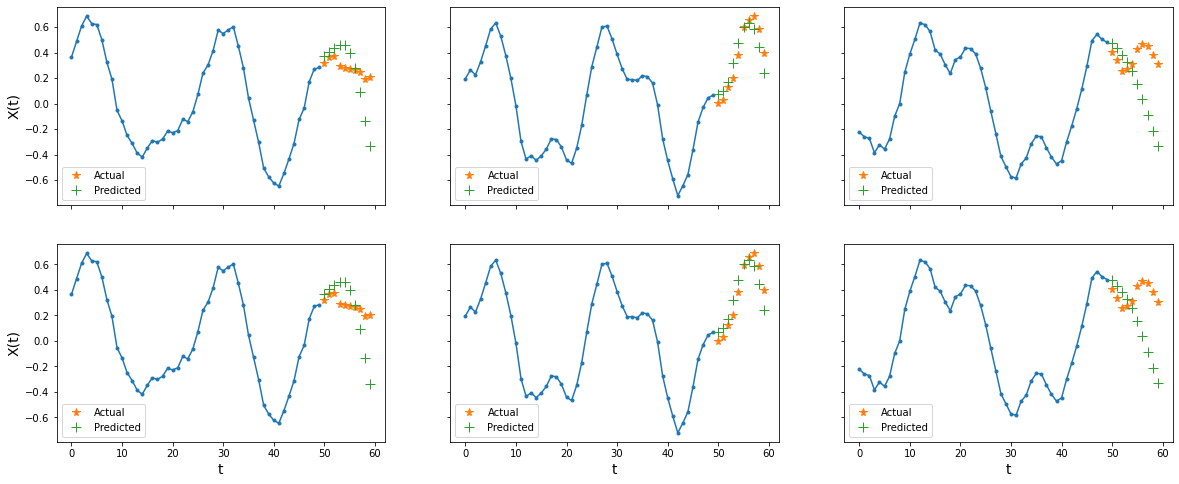

In [20]:
## =====> loop for next 10 values
## copy X_valid
np.random.seed(42)
tf.random.set_seed(42)

X_test_loop = np.copy(X_test)
for step_head in range(10):
    ## add new axis to be 3D
    y_pred_each_step = model_deepRNN_1.predict(X_test_loop[:, step_head:])[..., np.newaxis]  
    ## concatenate
    X_test_loop = np.concatenate([X_test_loop, y_pred_each_step], axis=1)

y_pred_conact = X_test_loop[:, n_steps:, :]  ### only the final 10 values

## check the mean of this loss of the 10 values
loss_mse_concat = np.mean(tf.keras.losses.mean_squared_error(y_test, y_pred_conact))
print('loss_mse_concat on test set =>', loss_mse_concat)
print()

### Visualize these resutls  ## for only the first batch in valid
fig, ax = plt.subplots(2, 3, figsize=(20, 8), sharex=True, sharey=True)

for row in range(2):
    for col in range(3):
        plt.sca(ax[row, col])
        plt.plot(np.squeeze(X_test_loop[col, :n_steps, :]), '.-')
        plt.plot(range(50, 60), np.squeeze(y_test[col]), '*', markersize=8, label='Actual')
        plt.plot(range(50, 60), np.squeeze(y_pred_conact[col]), '+', markersize=10, label='Predicted')
        if row==1:
            plt.xlabel('t', fontsize=14)
        if col==0:
            plt.ylabel('X(t)', fontsize=14)
        plt.legend()

### 1. Second Option => Change Final layer
`We can stack multiple layers in RNN, but note if you pass from RNN layer no.1 to RNN layer no.2, you should make hyperparameter (return_sequence) in layer no.1 to True, to be 3D array else you have an error, and if you pass from RNN layer no.1 to Dense layer no.2, you should set this hyperparameter to false as Dense layer required 2D not 3D and return_sequence=True, return 3D , so in this case we will set return_sequence=False` <br />



``` python
    ## case 1
    tf.keras.layer.SimpleRNN(20, return_sequences=True)
    tf.keras.layer.SimpleRNN(1)
    
    ## case 2
    tf.keras.layer.SimpleRNN(20, return_sequences=False)
    tf.keras.layer.Dense(1)
```

In [21]:
model_several = tf.keras.models.Sequential([
    ## return_sequences=True as the next layer is RNN
    tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    ## return_sequences=False as the next layer is Dense
    tf.keras.layers.SimpleRNN(20, return_sequences=False),
    tf.keras.layers.Dense(10)
])


## compile and fit the model for only 6 epochs ==> needs more but i save my time
model_several.compile(loss='mse', optimizer='adam')

history_several = model_several.fit(X_train, y_train, 
                                    validation_data=(X_valid, y_valid), 
                                    epochs=6, batch_size=32)

## loss through only 6 epochs reaches about 0.0138
## this Method is much better than the previous one

Epoch 1/6
219/219 [==============================] - 77s 345ms/step - loss: 0.0670 - val_loss: 0.0327
Epoch 2/6
219/219 [==============================] - 74s 339ms/step - loss: 0.0269 - val_loss: 0.0246
Epoch 3/6
219/219 [==============================] - 81s 369ms/step - loss: 0.0193 - val_loss: 0.0159
Epoch 4/6
219/219 [==============================] - 85s 388ms/step - loss: 0.0163 - val_loss: 0.0144
Epoch 5/6
219/219 [==============================] - 84s 384ms/step - loss: 0.0147 - val_loss: 0.0135
Epoch 6/6
219/219 [==============================] - 84s 385ms/step - loss: 0.0129 - val_loss: 0.0129


In [22]:
y_pred_valid = model_several.predict(X_valid)
loss_mse_valid = np.mean(tf.keras.losses.mean_squared_error(np.squeeze(y_valid), y_pred_valid))
print('loss_mse_valid =>', loss_mse_valid)
print()
## evaluate model on valid and test
loss_mse_valid = model_several.evaluate(X_valid, y_valid, verbose=0)
print('loss_mse_valid =>', loss_mse_valid)
loss_mse_test = model_several.evaluate(X_test, y_test, verbose=0)
print('loss_mse_test =>', loss_mse_test)

loss_mse_valid => 0.012932836

loss_mse_valid => 0.012932834215462208
loss_mse_test => 0.013014561496675014


### 1. Third Option => at each time step
`Instead of predicting the 10 next values at the last timestep , we will predict the next 10 values at each time step (sequence to sequence), this will stabilize and speed up training`
<br />
<br />
`Note that this approach, you must justify right your taregt as i am going to do`

In [23]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 50
batch_size = 10000
## take next 50 as predictors and next 10 as targtes
series_new = generate_time_series(use_batch_size=batch_size, use_n_steps=n_steps + 10)

## split as previous only for predictors, as i say above ==> we need to adjust the right target
## as in this approach at each time step i have 10 taget and 10 predicted values
## but i care more about the last 10 predicted values at the final time step
X_train = series_new[:7000, :n_steps, :]
X_valid = series_new[7000:9000, :n_steps, :]
X_test = series_new[9000:, :n_steps, :]

## solve this problem
y_total = np.empty((batch_size, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    y_total[..., step_ahead - 1] = series_new[..., step_ahead:step_ahead + n_steps, 0]
    
## for example y_total[0,0]=> batch_size=0 and timestep=0
print('y_total.shape =>', y_total.shape) 
y_train = y_total[:7000]
y_valid = y_total[7000:9000]
y_test = y_total[9000:]

## check shapes
print()
print('X_train.shape =>', X_train.shape)
print('y_train.shape =>', y_train.shape)
print()
print('X_valid.shape =>', X_valid.shape)
print('y_valid.shape =>', y_valid.shape)
print()
print('X_test.shape =>', X_test.shape)
print('y_test.shape =>', y_test.shape)  ## seems Good!

y_total.shape => (10000, 50, 10)

X_train.shape => (7000, 50, 1)
y_train.shape => (7000, 50, 10)

X_valid.shape => (2000, 50, 1)
y_valid.shape => (2000, 50, 10)

X_test.shape => (1000, 50, 1)
y_test.shape => (1000, 50, 10)


#### Note :

`Now we solve the Problem => at each batch at each timestep contains the predicted 10 values` <br />
`now we solve sequence to sequence RNN` <br />
`we must set the hyperparameter return-sequences=True in all layers, but we will predict 10 values in the last Dense layer and we discussed earlier that this Dense layer required 2D not 3D as return_sequences=True will return sequences of 3D not 2D ===> to solve this keras provides a layer called TimeDistributed, if you don't do that it will be handled and code will not give errors, but i recommend to you to use TimeDistributed(for more clear code)`

``` python
        ## example
        tf.keras.layer.SimpleRNN(20, return_sequences=True),
        tf.keras.layers.SimpleRNN(20, return_sequences=True),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10))
```

In [24]:
## build that model
model_best = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(20, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10))
])

## when compile , it is obvious that only i want the error at the last timestep, 
## but i predict the next 10 values at each timestep to stabilize the code and speed up training
## with more gradients avilable
## but when evaluating this model, we should evaluate the metric only at the last step
def last_time_step_mse(Y_true, Y_pred):
    mse_last = tf.keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
    return mse_last

## compile the model and pass the custom function to metric
model_best.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])

## fit the model
history_bestModel = model_best.fit(X_train, y_train, 
                                   validation_data=(X_valid, y_valid), 
                                   epochs=6, batch_size=32)

## loss through only 6 epochs on validation using the custom metric on last step
## val_last_time_step_mse: 0.0178  
## if you increase epochs it will be best than the previous

Epoch 1/6
219/219 [==============================] - 93s 412ms/step - loss: 0.0742 - last_time_step_mse: 0.0644 - val_loss: 0.0472 - val_last_time_step_mse: 0.0338
Epoch 2/6
219/219 [==============================] - 92s 422ms/step - loss: 0.0441 - last_time_step_mse: 0.0312 - val_loss: 0.0411 - val_last_time_step_mse: 0.0281
Epoch 3/6
219/219 [==============================] - 90s 411ms/step - loss: 0.0397 - last_time_step_mse: 0.0255 - val_loss: 0.0407 - val_last_time_step_mse: 0.0310
Epoch 4/6
219/219 [==============================] - 89s 407ms/step - loss: 0.0375 - last_time_step_mse: 0.0227 - val_loss: 0.0360 - val_last_time_step_mse: 0.0218
Epoch 5/6
219/219 [==============================] - 91s 416ms/step - loss: 0.0357 - last_time_step_mse: 0.0206 - val_loss: 0.0348 - val_last_time_step_mse: 0.0225
Epoch 6/6
219/219 [==============================] - 85s 386ms/step - loss: 0.0344 - last_time_step_mse: 0.0195 - val_loss: 0.0344 - val_last_time_step_mse: 0.0184


In [25]:
## check only for the last timestep
y_pred_valid = model_best.predict(X_valid)
loss_mse_valid = np.mean(tf.keras.losses.mean_squared_error(y_valid[:, -1], y_pred_valid[:, -1]))
print('loss_mse_valid =>', loss_mse_valid)
print()
## evaluate model on valid and test
loss_mse_valid = model_best.evaluate(X_valid, y_valid, verbose=0)[-1]
print('loss_mse_valid =>', loss_mse_valid)
loss_mse_test = model_best.evaluate(X_test, y_test, verbose=0)[-1]
print('loss_mse_test =>', loss_mse_test)

loss_mse_valid => 0.018389752

loss_mse_valid => 0.0183897502720356
loss_mse_test => 0.018355777487158775


## Handling Long Sequences
`Solving the Problem of Short term Memory ==> using (LSTM & GRU & Conv1D)`

#### `LSTM => Long Short term Memory Cell` 

In [26]:
model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.LSTM(20, return_sequences=True),   
    ## as I said TimeDistributed handle 3D to 2D then again to 3D
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10)) 
])

## as previous we only care the loss and metric of the last timestep
def last_time_step_mse(Y_true, Y_pred):
    mse_last = tf.keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
    return mse_last

## compile and fit the model
model_lstm.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])

history_lstm = model_lstm.fit(X_train, y_train, 
                             validation_data=(X_valid, y_valid), 
                             epochs=20, batch_size=32)

## loss through 20 epochs on validation using the custom metric on last step
## val_last_time_step_mse: 0.0085

Epoch 1/20
219/219 [==============================] - 6s 17ms/step - loss: 0.0770 - last_time_step_mse: 0.0618 - val_loss: 0.0533 - val_last_time_step_mse: 0.0312
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0455 - last_time_step_mse: 0.0230 - val_loss: 0.0401 - val_last_time_step_mse: 0.0168
Epoch 3/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0372 - last_time_step_mse: 0.0152 - val_loss: 0.0355 - val_last_time_step_mse: 0.0152
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0338 - last_time_step_mse: 0.0134 - val_loss: 0.0324 - val_last_time_step_mse: 0.0125
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0315 - last_time_step_mse: 0.0123 - val_loss: 0.0306 - val_last_time_step_mse: 0.0120
Epoch 6/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0299 - last_time_step_mse: 0.0113 - val_loss: 0.0291 - val_last_time_step_mse: 0.0106
Epoch 7/20
219/219 [==

In [27]:
## check only for the last timestep
y_pred_valid = model_lstm.predict(X_valid)
loss_mse_valid = np.mean(tf.keras.losses.mean_squared_error(y_valid[:, -1], y_pred_valid[:, -1]))
print('loss_mse_valid =>', loss_mse_valid)
print()
## evaluate model on valid and test
loss_mse_valid = model_lstm.evaluate(X_valid, y_valid, verbose=0)[-1]
print('loss_mse_valid =>', loss_mse_valid)
loss_mse_test = model_lstm.evaluate(X_test, y_test, verbose=0)[-1]
print('loss_mse_test =>', loss_mse_test)

loss_mse_valid => 0.008826784

loss_mse_valid => 0.008826781995594501
loss_mse_test => 0.008398681879043579


### Using Conv1D with GRU
`GRU => Gated Recurrent Unit solve the problem of peephole in LSTM, but using GRU with Conv1D is much better as Conv learn spatial patterns, and you can only use Conv1D and remove RNN layers`

In [28]:
model_The_best = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=20, kernel_size=4, 
                           strides=2, padding='valid', 
                           input_shape=[None, 1]),
    tf.keras.layers.GRU(20, return_sequences=True),
    tf.keras.layers.GRU(20, return_sequences=True),
     ## as I said TimeDistributed handle 3D to 2D then again to 3D
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10))
])

## as previous we only care the loss and metric of the last timestep
def last_time_step_mse(Y_true, Y_pred):
    mse_last = tf.keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
    return mse_last

## compile and fit the model
model_The_best.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])

history_bestModel = model_The_best.fit(X_train, y_train[:, 3::2, :], 
                                      validation_data=(X_valid, y_valid[:, 3::2, :]), 
                                      epochs=20, batch_size=32)

## loss through 20 epochs on validation using the custom metric on last step
## val_last_time_step_mse: 0.0075
## the best Model till now

Epoch 1/20
219/219 [==============================] - 6s 15ms/step - loss: 0.0679 - last_time_step_mse: 0.0596 - val_loss: 0.0463 - val_last_time_step_mse: 0.0378
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0386 - last_time_step_mse: 0.0310 - val_loss: 0.0339 - val_last_time_step_mse: 0.0271
Epoch 3/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0309 - last_time_step_mse: 0.0222 - val_loss: 0.0288 - val_last_time_step_mse: 0.0196
Epoch 4/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0271 - last_time_step_mse: 0.0171 - val_loss: 0.0261 - val_last_time_step_mse: 0.0164
Epoch 5/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0246 - last_time_step_mse: 0.0138 - val_loss: 0.0245 - val_last_time_step_mse: 0.0143
Epoch 6/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0233 - last_time_step_mse: 0.0122 - val_loss: 0.0228 - val_last_time_step_mse: 0.0114
Epoch 7/20
219/219 [==

In [29]:
## check only for the last timestep
y_pred_valid = model_The_best.predict(X_valid)
loss_mse_valid = np.mean(tf.keras.losses.mean_squared_error(y_valid[:, -1], y_pred_valid[:, -1]))
print('loss_mse_valid =>', loss_mse_valid)
print()
## evaluate model on valid and test
loss_mse_valid = model_The_best.evaluate(X_valid, y_valid[:, 3::2, :], verbose=0)[-1]
print('loss_mse_valid =>', loss_mse_valid)
loss_mse_test = model_The_best.evaluate(X_test, y_test[:, 3::2, :], verbose=0)[-1]
print('loss_mse_test =>', loss_mse_test)

loss_mse_valid => 0.008513491

loss_mse_valid => 0.008513492532074451
loss_mse_test => 0.008318323642015457


## Done!